<a href="https://colab.research.google.com/github/janajana1z/helmet-detection-yolo/blob/main/HardHat_YOLO_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
!pip install kaggle
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.9 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"janaazd","key":"f1215fe46025c250e6b583af06ff1c33"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d andrewmvd/hard-hat-detection
!unzip hard-hat-detection.zip


Streaming output truncated to the last 5000 lines.
  inflating: images/hard_hat_workers0.png  
  inflating: images/hard_hat_workers1.png  
  inflating: images/hard_hat_workers10.png  
  inflating: images/hard_hat_workers100.png  
  inflating: images/hard_hat_workers1000.png  
  inflating: images/hard_hat_workers1001.png  
  inflating: images/hard_hat_workers1002.png  
  inflating: images/hard_hat_workers1003.png  
  inflating: images/hard_hat_workers1004.png  
  inflating: images/hard_hat_workers1005.png  
  inflating: images/hard_hat_workers1006.png  
  inflating: images/hard_hat_workers1007.png  
  inflating: images/hard_hat_workers1008.png  
  inflating: images/hard_hat_workers1009.png  
  inflating: images/hard_hat_workers101.png  
  inflating: images/hard_hat_workers1010.png  
  inflating: images/hard_hat_workers1011.png  
  inflating: images/hard_hat_workers1012.png  
  inflating: images/hard_hat_workers1013.png  
  inflating: images/hard_hat_workers1014.png  
  inflating: images

In [5]:
import os
import xml.etree.ElementTree as ET

# Create labels folder
os.makedirs("labels", exist_ok=True)

def convert(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x*dw, y*dh, w*dw, h*dh)

for xml_file in os.listdir("annotations"):
    tree = ET.parse(os.path.join("annotations", xml_file))
    root = tree.getroot()

    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)

    with open(os.path.join("labels", xml_file.replace(".xml", ".txt")), "w") as out_file:
        for obj in root.iter("object"):
            cls = obj.find("name").text

            if cls == "helmet":
                cls_id = 0
            elif cls == "head":
                cls_id = 1
            else:
                continue  # Ignore person

            xmlbox = obj.find("bndbox")
            b = (
                float(xmlbox.find("xmin").text),
                float(xmlbox.find("xmax").text),
                float(xmlbox.find("ymin").text),
                float(xmlbox.find("ymax").text),
            )

            bb = convert((w, h), b)
            out_file.write(f"{cls_id} {' '.join(map(str, bb))}\n")

print("Conversion Complete!")


Conversion Complete!


In [6]:
import shutil
from sklearn.model_selection import train_test_split

# Create folders
os.makedirs("dataset/images/train", exist_ok=True)
os.makedirs("dataset/images/val", exist_ok=True)
os.makedirs("dataset/labels/train", exist_ok=True)
os.makedirs("dataset/labels/val", exist_ok=True)

image_files = os.listdir("images")

train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

for file in train_files:
    shutil.copy(f"images/{file}", "dataset/images/train/")
    shutil.copy(f"labels/{file.replace('.png', '.txt').replace('.jpg', '.txt')}",
                "dataset/labels/train/")

for file in val_files:
    shutil.copy(f"images/{file}", "dataset/images/val/")
    shutil.copy(f"labels/{file.replace('.png', '.txt').replace('.jpg', '.txt')}",
                "dataset/labels/val/")

print("Train/Val Split Complete!")


Train/Val Split Complete!


In [7]:
%%writefile data.yaml

path: dataset
train: images/train
val: images/val

names:
  0: helmet
  1: no_helmet


Writing data.yaml


In [8]:
!yolo detect train data=data.yaml model=yolov8s.pt epochs=30 imgsz=640


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, k

In [9]:
!yolo detect val model=runs/detect/train/weights/best.pt data=data.yaml

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3541.8±1186.7 MB/s, size: 261.6 KB)
val: Scanning /content/dataset/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 174.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 3.6it/s 17.3s
                   all       1000       5065      0.936      0.878      0.941      0.625
                helmet        922       3880      0.955      0.905      0.965      0.647
             no_helmet        186       1185      0.916      0.851      0.917      0.603
Speed: 1.3ms preprocess, 9.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [10]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=dataset/images/val


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

image 1/1000 /content/dataset/images/val/hard_hat_workers1.png: 640x640 9 helmets, 15.5ms
image 2/1000 /content/dataset/images/val/hard_hat_workers100.png: 640x640 6 helmets, 15.5ms
image 3/1000 /content/dataset/images/val/hard_hat_workers1012.png: 640x640 5 helmets, 16.2ms
image 4/1000 /content/dataset/images/val/hard_hat_workers1015.png: 640x640 1 helmet, 16.2ms
image 5/1000 /content/dataset/images/val/hard_hat_workers102.png: 640x640 3 helmets, 16.2ms
image 6/1000 /content/dataset/images/val/hard_hat_workers1020.png: 640x640 8 helmets, 16.2ms
image 7/1000 /content/dataset/images/val/hard_hat_workers1022.png: 640x640 4 helmets, 16.2ms
image 8/1000 /content/dataset/images/val/hard_hat_workers1024.png: 640x640 8 no_helmets, 16.2ms
image 9/1000 /content/dataset/images/val/hard_hat_workers1043.png: 640x640 4 helmets, 16.2ms


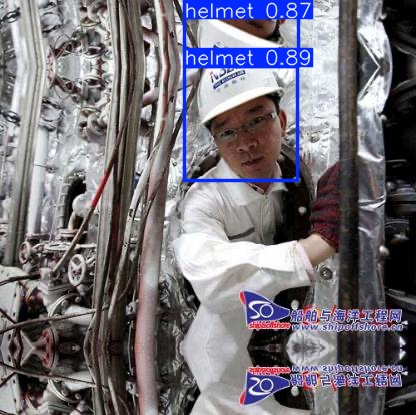

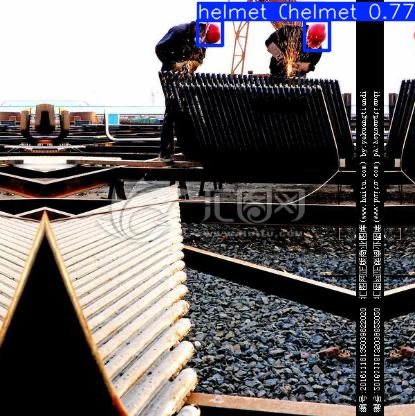

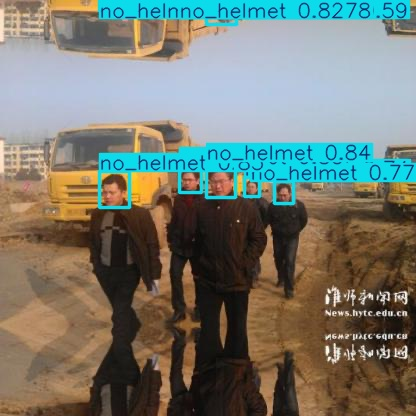

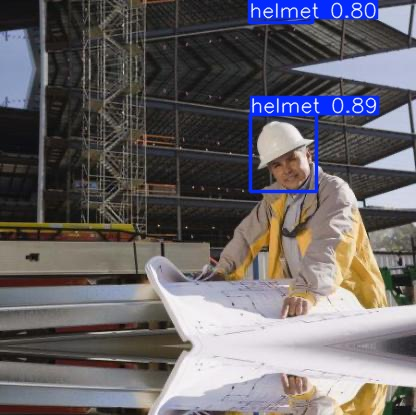

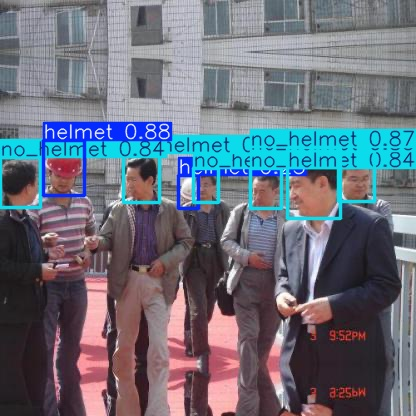

In [11]:
import glob
from IPython.display import Image, display

predicted_images = glob.glob("runs/detect/predict/*.jpg")

for img in predicted_images[:5]:  # show first 5
    display(Image(filename=img))